# Density of States
# 1. Introduction
- In this example, we calculate the phonon (vibrational) density of states (DOS) of graphene at 300 K and zero pressure. The method is based on the velocity auto-correlation (VAC) function. The DOS is calculated as the Fourier transform of the VAC [[Dickey 1969]](https://doi.org/10.1103/PhysRev.188.1407).

### Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [gpyumd](https://github.com/AlexGabourie/gpyumd) package.

In [2]:
from pylab import *
from ase.build import graphene_nanoribbon
from ase.io import write
from gpyumd.load import load_dos, load_vac

# 2. Preparing the Inputs
- We use a sheet of graphene consisting of 8640 carbon atoms and use a Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).

## Generate the  [model.xyz](https://gpumd.org/gpumd/input_files/model_xyz.html) file:

In [3]:
gnr = graphene_nanoribbon(60, 36, type='armchair', sheet=True, vacuum=3.35/2, C_C=1.44)
gnr.euler_rotate(theta=90)
l = gnr.cell.lengths()
gnr.cell = gnr.cell.new((l[0], l[2], l[1]))
l = l[2]
gnr.center()
gnr.pbc = [True, True, False]
gnr

Atoms(symbols='C8640', pbc=[True, True, False], cell=[149.64918977395098, 155.52, 3.35])

In [4]:
write("model.xyz", gnr)

- The first few lines of the [model.xyz](https://gpumd.org/gpumd/input_files/model_xyz.html) file are:
```
8640
Lattice="149.64918977395098 0.0 0.0 0.0 155.52 0.0 0.0 0.0 3.35" Properties=species:S:1:pos:R:3 pbc="T T F"
C      147.77857490       0.72000000       1.67500000
C      149.02565148       1.44000000       1.67500000
C      149.02565148       2.88000000       1.67500000
C      147.77857490       3.60000000       1.67500000
```

- Explanations for the first line:
  - The first number states that the number of particles is 8640.

- Explanations for the second line:
   - This line consists of a number of keyword=value pairs separated by spaces. Spaces before and after = are allowed. All the characters are case-insensitive.
   - lattice="ax ay az bx by bz cx cy cz" gives the box vectors.
   - properties=property_name:data_type:number_of_columns. We only read the following items:
        - species:S:1 atom type (Mandatory)
        - pos:R:3 position vector (Mandatory)
        - mass:R:1 mass (Optional: default mass values will be used when this is missing), not included here.
        - vel:R:3 velocity vector (Optional), not included here.
        - group:I:number_of_grouping_methods grouping methods (Optional), not included here.

## The <code>[run.in](https://gpumd.org/gpumd/input_files/run_in.html)</code> file:
The <code>run.in</code> input file is given below:<br>
```
potential   ../../../potentials/tersoff/Graphene_Lindsay_2010_modified.txt
velocity    300

ensemble    npt_ber 300 300 100 0 0 0 53.4059 53.4059 53.4059 2000 
time_step   1     
dump_thermo 100     
run         200000

ensemble    nve 
compute_dos 5 200 400.0
run         200000 
```
 - The first line uses the [potential](https://gpumd.org/gpumd/input_parameters/potential.html) keyword to define the potential to be used, which is specified in the file [Graphene_Lindsay_2010_modified.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Graphene_Lindsay_2010_modified.txt).

 - The second line uses the [velocity](https://gpumd.org/gpumd/input_parameters/velocity.html) keyword and sets the velocities to be initialized with a temperature of 300 K. 

 - There are two runs:
   - The first [run](https://gpumd.org/gpumd/input_parameters/run.html) serves as the equilibration stage, where the NPT [ensemble](https://gpumd.org/gpumd/input_parameters/ensemble.html) (the Berendsen method) is used. The temperature is 300 K and the pressures are zero in all the directions. The coupling constants are 100 and 2000 time steps for the thermostat and the barostat (The elastic constant, or inverse compressibility parameter needed in the barostat is estimated to be 53.4059 GPa; this only needs to be correct up to the order of magnitude.), respectively. The [time_step](https://gpumd.org/gpumd/input_parameters/time_step.html) for integration is 1 fs. There are $2\times 10^5$ steps (200 ps) for this [run](https://gpumd.org/gpumd/input_parameters/run.html) and the thermodynamic quantities will be output every 1000 steps. 
   - The second [run](https://gpumd.org/gpumd/input_parameters/run.html) serves as the production [run](https://gpumd.org/gpumd/input_parameters/run.html), where the NVE [ensemble](https://gpumd.org/gpumd/input_parameters/ensemble.html) is used. The line with [compute_dos](https://gpumd.org/gpumd/input_parameters/compute_dos.html) means that velocities will be recorded every 5 steps (5 fs) and 200 VAC data (the maximum correlation time is then about 1 ps) will be calculated. The last parameter in this line is the maximum angular frequency considered, $\omega_{\rm max} = 2\pi\nu_{\rm max} =400$ THz, which is large enough for graphene. The production [run](https://gpumd.org/gpumd/input_parameters/run.html) lasts 200 ps.

# 3. Results and Discussion
### Computation Time
 - Using a GeForce RTX 2080 Ti GPU, the NEMD simulation takes about 1.5 minutes.
 - The speed of this simulation is about $3.3\times 10^7$ atom x step / second.

### Figure Properties

In [5]:
aw = 2
fs = 16
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

## Plot DOS and VAC
 - The [dos.out](https://gpumd.org/gpumd/output_files/dos_out.html) and [mvac.out](https://gpumd.org/gpumd/output_files/mvac_out.html) output files are loaded and processed to create the following figure.

In [7]:
num_corr_steps = 200
dos = load_dos(num_dos_points=num_corr_steps)['run0']
vac = load_vac(num_corr_steps)['run0']
dos['DOSxyz'] = dos['DOSx']+dos['DOSy']+dos['DOSz']
vac['VACxyz'] = vac['VACx']+vac['VACy']+vac['VACz']
vac['VACxyz'] /= vac['VACxyz'].max()
print('DOS:', list(dos.keys()))
print('VAC:', list(vac.keys()))

DOS: ['nu', 'DOSx', 'DOSy', 'DOSz', 'DOSxyz']
VAC: ['t', 'VACx', 'VACy', 'VACz', 'VACxyz']


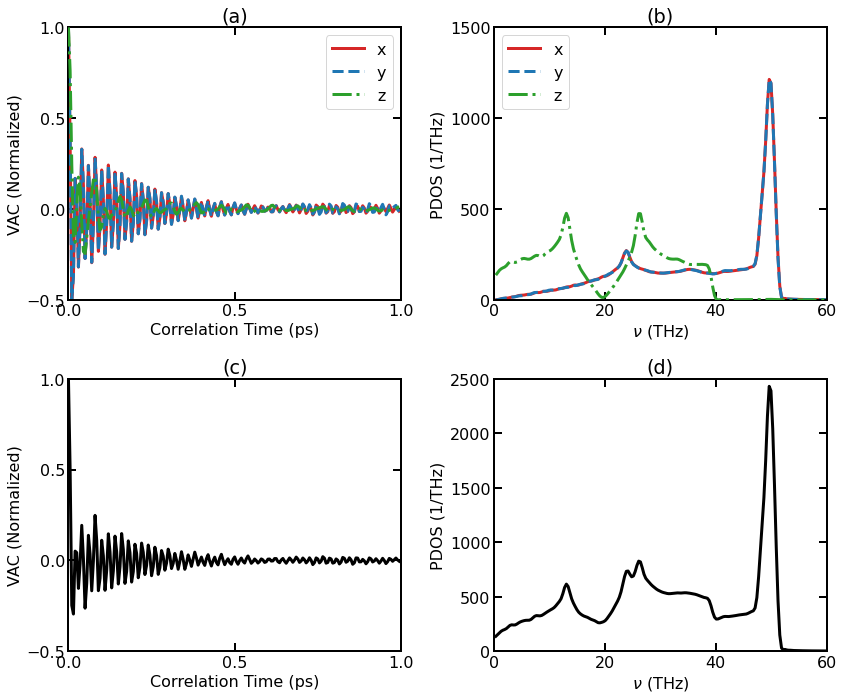

In [8]:
figure(figsize=(12,10))
subplot(2,2,1)
set_fig_properties([gca()])
plot(vac['t'], vac['VACx']/vac['VACx'].max(), color='C3',linewidth=3)
plot(vac['t'], vac['VACy']/vac['VACy'].max(), color='C0', linestyle='--',linewidth=3)
plot(vac['t'], vac['VACz']/vac['VACz'].max(), color='C2', linestyle='-.',zorder=100,linewidth=3)
xlim([0,1])
gca().set_xticks([0,0.5,1])
ylim([-0.5, 1])
gca().set_yticks([-0.5,0,0.5,1])
ylabel('VAC (Normalized)')
xlabel('Correlation Time (ps)')
legend(['x','y', 'z'])
title('(a)')

subplot(2,2,2)
set_fig_properties([gca()])
plot(dos['nu'], dos['DOSx'], color='C3',linewidth=3)
plot(dos['nu'], dos['DOSy'], color='C0', linestyle='--',linewidth=3)
plot(dos['nu'], dos['DOSz'], color='C2', linestyle='-.',zorder=100, linewidth=3)
xlim([0, 60])
gca().set_xticks(range(0,61,20))
ylim([0, 1500])
gca().set_yticks(np.arange(0,1501,500))
ylabel('PDOS (1/THz)')
xlabel(r'$\nu$ (THz)')
legend(['x','y', 'z'])
title('(b)')

subplot(2,2,3)
set_fig_properties([gca()])
plot(vac['t'], vac['VACxyz'], color='k',linewidth=3)
xlim([0,1])
gca().set_xticks([0,0.5,1])
ylim([-0.5, 1])
gca().set_yticks([-0.5,0,0.5,1])
ylabel('VAC (Normalized)')
xlabel('Correlation Time (ps)')
title('(c)')

subplot(2,2,4)
set_fig_properties([gca()])
plot(dos['nu'], dos['DOSxyz'], color='k',linewidth=3)
xlim([0, 60])
gca().set_xticks(range(0,61,20))
ylim([0, 2500])
gca().set_yticks(np.arange(0,2501,500))
ylabel('PDOS (1/THz)')
xlabel(r'$\nu$ (THz)')
title('(d)')

tight_layout()
show()

**(a)** Normalized VAC for individual directions. **(b)** DOS for individual directions. **(c)** Total Normalized VAC. **(d)** Total DOS.

 - For 3D isotropic systems, the results along different directions are equivalent and can be averaged, but for 2D materials like graphene, it is natural to consider the in-plane part (the $x$ and $y$ directions in the simulation) and the out-of-plane part (the $z$ direction) separately. It can be seen that the two components behave very differently. We can see that the cutoff frequency for the out-of-plane component (about 40 THz) is smaller than that for the in-plane component (about 52 THz).

## Plot Quantum-Corrected Heat Capacity

 - In classical MD simulations, the heat capacity per atom is almost $k_{\rm B}$ even at temperatures that are much lower than the Debye temperature. With the DOS available, one can obtaine the following quantum heat capacity per atom in direction $\alpha$:
$$
C_{\alpha}(T) = \int_0^{\infty} \frac{d\omega}{2\pi} \rho_{\alpha}(\omega) \frac{x^2 \exp(x)}{(\exp(x)-1)^2},
$$
where 
$$
x=\frac{\hbar\omega}{k_{\rm B} T}
$$
and $\rho_{\alpha}(\omega)$ is the density of states in direction $\alpha$ normalized to 1:
$$
\int_0^{\infty} \frac{d\omega}{2\pi} \rho_{\alpha}(\omega) = 1.
$$

In [9]:
temperatures = np.arange(100,5001,100)  # [K]
num_atoms = len(gnr)
Cx, Cy, Cz = list(), list(), list()  # [k_B/atom] Heat capacity per atom
hnu = 6.63e-34*dos['nu']*1.e12  # [J]

for temperature in temperatures:
    kBT = 1.38e-23*temperature  # [J]
    x = hnu/kBT
    expr = np.square(x)*np.exp(x)/(np.square(np.expm1(x)))
    Cx.append(np.trapz(dos['DOSx']*expr, dos['nu'])/num_atoms)
    Cy.append(np.trapz(dos['DOSy']*expr, dos['nu'])/num_atoms)
    Cz.append(np.trapz(dos['DOSz']*expr, dos['nu'])/num_atoms)

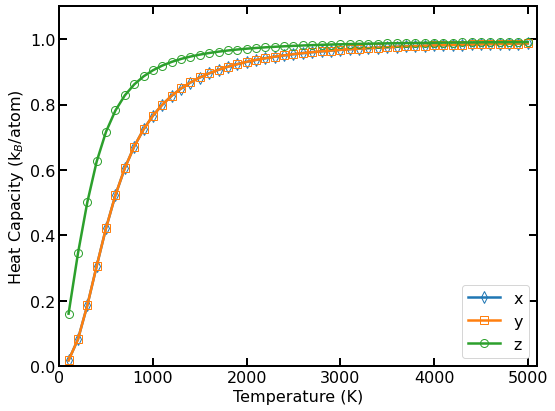

In [10]:
figure(figsize=(8,6))
set_fig_properties([gca()])
mew, ms, mfc, lw = 1, 8, 'none', 2.5
plot(temperatures, Cx, lw=lw,marker='d',mfc=mfc,ms=ms,mew=mew)
plot(temperatures, Cy, lw=lw,marker='s',mfc=mfc,ms=ms,mew=mew)
plot(temperatures, Cz, lw=lw,marker='o',mfc=mfc,ms=ms,mew=mew)
xlim([0,5100])
gca().set_xticks(range(0,5001,1000))
ylim([0, 1.1])
gca().set_yticks(np.linspace(0,1,6))
ylabel(r'Heat Capacity (k$_B$/atom)')
xlabel('Temperature (K)')
legend(['x','y','z'])

tight_layout()
show()

Quantum heat capacity per atom as a function of temperature.

 - The above figure shows the calculated per-atom quantum heat capacity in different directions.

 - Again, the in-plane ($x$ and $y$ directions) and out-of-plane ($z$ direction) phonons behave differently.

 - For every direction, the quantum heat capacity increases from 0 to $k_{\rm B}$ with increasing temperature.

 - One can also calculate the Debye temperature as a function of temperature $\Theta(T)$, but we leave it to the reader.

# 4. References
- [Dickey 1969] J. M. Dickey and A. Paskin, [Computer Simulation of the Lattice Dynamics of Solids](https://doi.org/10.1103/PhysRev.188.1407), Phys. Rev. **188**, 1407 (1969).
- [Lindsay 2010] L. Lindsay and D.A. Broido, [Optimized Tersoff and Brenner emperical potential parameters for lattice dynamics and phonon thermal transport in carbon nanotubes and graphene](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B, **81**, 205441 (2010).
- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B **39**, 5566(R) (1989).